In [1]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from ce_apg import do_one_rollout, cem_apg

from functools import partial

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "save_ce_apg_ant"

0.0023728155


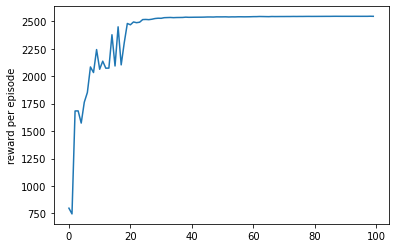

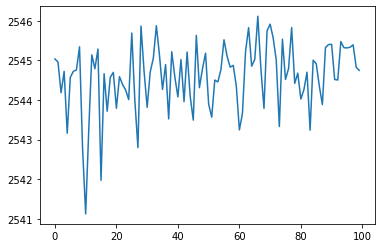

 Iteration 99 --------------------------------
0 : reward: 2534.214599609375 -> 2545.121826171875
1 : reward: 2532.90576171875 -> 2544.92578125
2 : reward: 2534.2021484375 -> 2544.900390625
3 : reward: 2516.10205078125 -> 2544.809326171875
4 : reward: 2533.472900390625 -> 2544.752685546875
5 : reward: 2529.673828125 -> 2544.671142578125
6 : reward: 2522.044189453125 -> 2544.652587890625
7 : reward: 2534.46533203125 -> 2544.481689453125
---
8 : reward: 2536.401611328125 -> 2544.354248046875
9 : reward: 2471.130859375 -> 2544.328857421875
10 : reward: 2536.748779296875 -> 2544.3212890625
11 : reward: 2518.6572265625 -> 2544.1962890625
12 : reward: 2535.45654296875 -> 2542.697509765625
13 : reward: 2536.072998046875 -> 2539.754150390625
14 : reward: 2517.251220703125 -> 2539.1611328125
15 : reward: 2475.07177734375 -> 2534.125732421875
16 : reward: 1316.9759521484375 -> 2525.60546875
17 : reward: 2490.66015625 -> 2484.239990234375
18 : reward: 2499.639404296875 -> 2471.436767578125
19 : r

In [25]:
env_name = "acrobot" #"inverted_pendulum_swingup", "inverted_double_pendulum_swingup"]:
episode_length = 400
action_repeat = 1
env_fn = create_fn(env_name = env_name, episode_length=episode_length, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()

policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)
policy = GruController(env.observation_size, env.action_size, policy_size)
pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))

seed = 0
inference_fn, params, rewards = cem_apg(env_fn,
                                        100,
                                        key=jax.random.PRNGKey(seed),
                                        episode_length = episode_length,
                                        action_repeat = action_repeat,
                                        apg_epochs = 100,
                                        batch_size = 4,
                                        zero_params=False,
                                        truncation_length = None,
                                        #learning_rate = 1e-4,
                                        clipping = 1e9,
                                        initial_std = 0.05,
                                        num_elite = 8,
                                        eps = 0.0,
                                        normalize_observations=True,
                                        policy = policy,
                                        learning_schedule = [-3, -5]
                                       )

model.save_params(f"{save_dir}/{env_name}_params_{seed}", params)
pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{seed}", "wb"))



In [29]:
from brax.io import model
import ce_apg

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=5)
state = jit_env_reset(rng=rng)
h = np.zeros_like(state.obs)
r = []

while not state.done:
  rollout.append(state)
  r.append(state.reward)
  h, act = jit_inference_fn(params, h, state.obs)
  state = jit_env_step(state, act)

print(sum(r))
HTML(html.render(env.sys, [s.qp for s in rollout]))

2532.2917


Text(0.5, 1.0, 'Acrobot Rollout SAC')

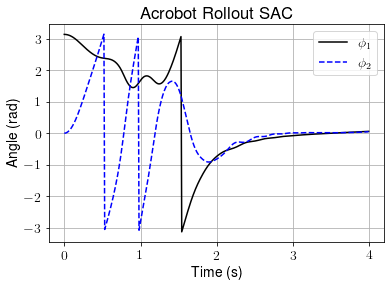

In [30]:
obs = [s.obs for s in rollout]
pos = np.array(obs)[:,:2]
t = [i*0.01 for i in range(pos.shape[0])]
plt.rcParams['text.usetex'] = True
plt.rcParams["font.serif"] = "Helvetica"
plt.rcParams["font.size"] = 14

plt.plot(t, pos[:,0], 'k');
plt.plot(t, pos[:,1], 'b--');
plt.ylabel('Angle (rad)')
plt.xlabel('Time (s)')
plt.legend([r'$\phi_{1}$', r'$\phi_{2}$'])


plt.grid()
plt.title('Acrobot Rollout SAC')